<br><br>

<img src="https://raw.githubusercontent.com/SmilodonCub/DS4VS/master/Homework/banner4.png" width="100%" style="margin-left:auto; margin-right:auto">


<br>

# Homework 4: Simple Linear Regression

Last week we looked at Simple Linear Regression by evaluating the relationship of receptive field size for Parvocellular Retinal Ganglion Cells (P RGCs) as a function of eccenticity. Let's revisit this code and perform a few quick exercizes with the data.

The goals for this homework:

* revisit simple linear regression for P cells
* use diagnostic plots to evaluate the linear regression
* perform and evaluate a simple linear regression on M cells
* perform a multiple linear regression on the dataset to evaluate the statistical significance of cell class on RF size

### RGC RF size ~ Eccentricity

The following code will import a dataset derived from [Croner & Kaplan's (1994)](https://reader.elsevier.com/reader/sd/pii/0042698994E0066T?token=CCFEF99BAE57CBEB1F03D2F88623103F607C2DA81BEABC6528E8658F21C82931BE9A33EF814DEC7E34BE9CA81D188652&originRegion=us-east-1&originCreation=20211011213722) influencial paper describing the RF sizes and eccentricities of Magnocellular and Parvocellular RGCs in the macaque retina

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url = 'https://raw.githubusercontent.com/SmilodonCub/DATA621/master/macaqueRGCs.csv'
df = pd.read_csv( url )
df.head()

,Eccentricity,Radius,Class
0,3.525,0.098,M
1,6.234,0.093,M
2,6.531,0.122,M
3,7.718,0.105,M
4,8.386,0.123,M


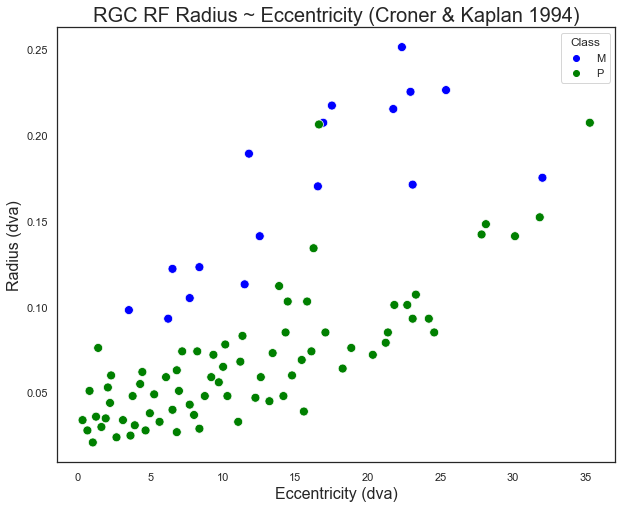

In [3]:
# render a quick plot of some of the data
palette = {'P':'green', 'M':'blue'}
plt.figure(figsize=(10,8))
sns.set_theme(style="white", palette=None)
ax = sns.scatterplot( x = 'Eccentricity', y = 'Radius', hue = 'Class', data = df, s = 80, palette=palette)
ax.set_xlabel( 'Eccentricity (dva)', fontsize= 16 )
ax.set_ylabel( 'Radius (dva)', fontsize= 16 )
ax.set_title( 'RGC RF Radius ~ Eccentricity (Croner & Kaplan 1994)', fontsize= 20)
plt.show()

<br>

## M-cell RF size ~ Eccentricity

Let's revisit the same code we saw in lecture to fit a simple linear regression model to the M-cell data

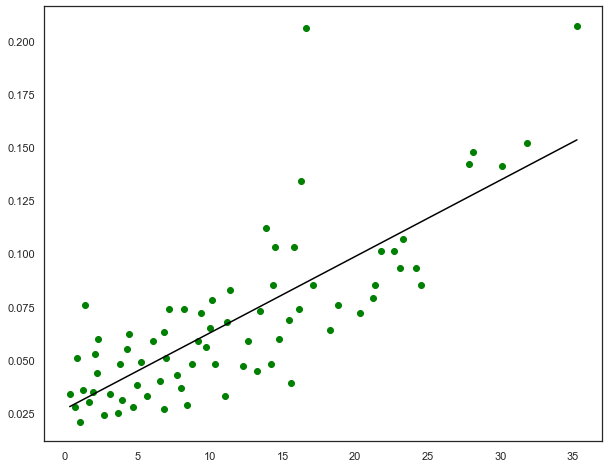

In [4]:
# visualize the residuals for the best fit for P cells
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
dfP = df.loc[df['Class']=='P']
lin_reg.fit( dfP['Eccentricity'].values.reshape(-1, 1), dfP['Radius'].values.reshape(-1, 1))
bfly = lin_reg.predict( dfP['Eccentricity'].values.reshape(-1, 1) )

fig, ax = plt.subplots( figsize = (10,8) )
ax.scatter( x = dfP['Eccentricity'], y = dfP['Radius'], color = 'green')
ax.plot( dfP['Eccentricity'], bfly, 'k' )
plt.show()

In [5]:
# return the model coefficients
print( 'slope: ', lin_reg.coef_[0][0].round(5), '\tintercept: ', lin_reg.intercept_[0].round(5))

slope:  0.00359 	intercept:  0.02681


We have fit a linear regression model to the data. However, before we can draw inferences from the model fit, we have to evaluate the model to determine if a linear model was appropriate for the data.  

## Evaluating Linearity Assumptions

When we chose to fit a linear model to some data, we make several key assumptions about the data:  

* **Linearity** - there exists a linear relationship between the target and predictor variables
If this is true then we should be able to show the following about the model residuals:
* **Independence** - the is no pattern between residuals (ex: no periodicity)
* **Homoscedasticity** - the residuals have constant variance (ex: there is no cone-like pattern to the residuals)
4. **Normality** - the residuals have a normal distribution about the prediction result

For more information: [The Four Assumptions of Linear Regression](https://www.statology.org/linear-regression-assumptions/)  

The following figure illustrates situations where the linearity assumptions have not been met:
<img src="https://raw.githubusercontent.com/SmilodonCub/DS4VS/master/Homework/assumptions.png" width="100%" style="margin-left:auto; margin-right:auto">

This figure is from a really great (and free) statistics text, [OpenIntro Statistics](https://www.openintro.org/book/os/). It gives super clear explanations of foundational statistics concepts. The only downside is that the problems & code are all in `R`, not Python.

<br>

## Diagnostic Plots in Python


Before we can move on and draw conclusions about how RGC RF size varies as Eccentricity increases, we need to evaluate our data to assess whether these criteria are reasonably met. We can do this by looking at diagnostic plots of the model's residuals. Unfortunately, it is difficult to generate diagnostic plots with `scikit-learn`. Here we will use some functions that use a different library (`statsmodels`) to fit the linear regression:

In [6]:
import scipy.stats as stats
import statsmodels.api as sm
from pandas.core.frame import DataFrame
from statsmodels.nonparametric.smoothers_lowess import lowess

def linear_regression(df, x_cols, y_cols):
    """Perform a univariate regression and store results in a new data frame.

    Args:
        df (DataFrame): orginal data set with x and y.
        x_cols: a list of predictor column names
        y_cols: a list with the target column name

    Returns:
        DataFrame: another dataframe with raw data and results.
    """
    mod = sm.OLS(endog=df[y_cols], exog=df[x_cols]).fit()
    influence = mod.get_influence()

    res = df.copy()
    res['resid'] = mod.resid
    res['fittedvalues'] = mod.fittedvalues
    res['resid_std'] = mod.resid_pearson
    res['sqrt_resid_std'] = res['resid_std'].abs().transform('sqrt')
    res['leverage'] = influence.hat_matrix_diag
    res['norm_resid'] = mod.get_influence().resid_studentized_internal
    res['cooks'] = influence.cooks_distance[0]
    res['cooks_pval'] = influence.cooks_distance[1]
    return mod, res


def plot_diagnosis(df: DataFrame):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (10,8))
    plt.style.use('seaborn')

    # Residual against fitted values.
    smooth = lowess( endog = df.resid, exog =  df.fittedvalues)
    index, data = np.transpose(smooth)
    axs[0,0].scatter( x = df.fittedvalues, y = df.resid, ls = 'None' )
    axs[0,0].plot( index, data, 'r' )
    axs[0,0].axhline( y=0, color='k')
    axs[0,0].set_ylabel( 'Residual' )
    axs[0,0].set_xlabel( 'fitted' )

    # qqplot
    sm.qqplot(
        df['norm_resid'], dist=stats.t, fit=True, line='45',
        ax=axs[0, 1]#, c='#4C72B0'
    )
    axs[0,1].set_title('Normal Q-Q')

    # The scale-location plot.
    smooth = lowess( endog = df.sqrt_resid_std, exog =  df.fittedvalues)
    index, data = np.transpose(smooth)
    axs[1,0].scatter(
        x=df.fittedvalues, y=df.sqrt_resid_std
    )
    axs[1,0].plot( index, data, 'r' )
    axs[1,0].set_xlabel('Fitted values')
    axs[1,0].set_ylabel('Sqrt(|standardized residuals|)')
    axs[1,0].set_title('Scale-Location')

    # Standardized residuals vs. leverage
    smooth = lowess( endog = df.resid_std, exog =  df.leverage)
    index, data = np.transpose(smooth)
    axs[1,1].scatter(
        x=df.leverage, y=df.resid_std#, ax=axes[1, 1]
    )
    axs[1,1].axhline(y=0, color='grey', linestyle='dashed')
    axs[1,1].plot( index, data, 'r' )
    axs[1,1].set_xlabel('Leverage')
    axs[1,1].set_ylabel('standardized residuals')
    axs[1,1].set_title('Residuals vs Leverage')
    leverage_top_3 = np.flip(np.argsort(df.cooks), 0)[:3]
    for i in leverage_top_3:
        axs[1,1].annotate(i, xy=(df.leverage[i],
                                 df.norm_resid[i]));

    plt.tight_layout()
    plt.show()
    


                                 OLS Regression Results                                
Dep. Variable:                 Radius   R-squared (uncentered):                   0.868
Model:                            OLS   Adj. R-squared (uncentered):              0.867
Method:                 Least Squares   F-statistic:                              481.4
Date:                Mon, 15 Nov 2021   Prob (F-statistic):                    7.27e-34
Time:                        19:58:53   Log-Likelihood:                          158.03
No. Observations:                  74   AIC:                                     -314.1
Df Residuals:                      73   BIC:                                     -311.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

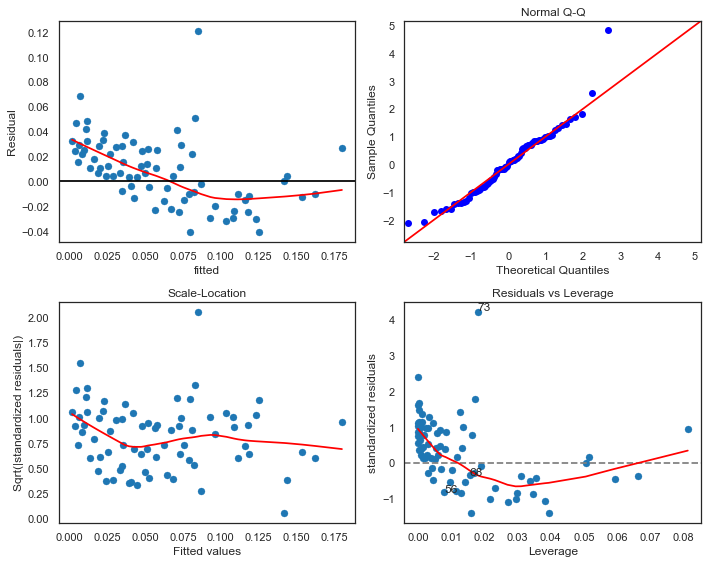

In [7]:
data = [ dfP["Eccentricity"], dfP["Radius"]]
headers = ['x','y']
df_diagnostic = pd.concat(data, axis=1, keys=headers)
#res = linear_regression( df_diagnostic )
mod, res = linear_regression( df=dfP, x_cols=["Eccentricity"], y_cols=["Radius"] )
print( mod.summary() )
plot_diagnosis( res )

I've made some changes (and found some mistakes) to the [source code for diagnostic plots](https://stackoverflow.com/questions/46607831/python-linear-regression-diagnostic-plots-similar-to-r)  that i presented in lecture

## Unpacking Diagnostic Plots

Let's spend some time walking through these four plots.  

1. **Residuals vs Fitted** - The magnitude of the residual is plotted as a function of the predicted value. This plot shows whether the residuals have any non-linear patterns. Ideally, the residuals should cluster evenly across the dotted line as a function of the fitted values. The red line is a nonparametric (lowess) fit to the data; ideally this line should be very close to y=0. However, looking at our results, this does not appear to be the case as the residuals are positive for the smallest fitted values but become progressively more negative.

2. **Normal Q-Q** - take the observed values, sort in order of magnitude and plot against the distribution of theoretical (standard Normal distribution) values sorted by magnitude. If the observed values are drawn from a normal distribution, then the points should plot along the 45$^{\circ}$ line. For the most part, we see that with a few exceptions, the data plots along the red line. The data appears reasonably linear with the exception of an outlier.

3. **Scale-Location** - This plot is similar to the Residuals vs Fitted, however the square root of the standardized residuals are plotted so that we can more readily evaluate whether the variance of the residuals is constant across fitted values.

4. **Residuals vs Leverage** - helps to identify influential cases. Points of high influence on the regression result are likely to have both a high leverage score and large (+/-) deviation; such points would be in the upper and lower right hand of the plot

We can also use the cooks distance of the points to find high leverage points. Typically, a point has high leverage if the cooks score is greater than 4/(num observations) and we would look to remove points with a cooks distance greater than 0.5. Especially if there are few similar points.

In [8]:
# identify highly influential points
res[ res['cooks'] > 4/74 ]

,Eccentricity,Radius,Class,resid,fittedvalues,resid_std,sqrt_resid_std,leverage,norm_resid,cooks,cooks_pval
72,16.252,0.134,P,0.051020,0.082980,1.772030,1.331176,0.017256,1.787520,0.056104,0.813427
73,16.623,0.206,P,0.121126,0.084874,4.206934,2.051081,0.018052,4.245429,0.331353,0.566634
85,24.564,0.085,P,-0.040419,0.125419,-1.403836,1.184836,0.039420,-1.432351,0.084194,0.772515
90,35.288,0.207,P,0.026826,0.180174,0.931717,0.965255,0.081353,0.972097,0.083684,0.773186


From the data above, we can see that there are several observations with high leverage, but none with a cooks distance $\gt 0.5$.

## Let's try again!

The model diagnostics do not look as great as you hoped,but you are undetered! You feel that perhaps there is a linear relation between the target and predictor, but perhaps it only holds up to a certain Eccentricity.

* Choose a cutoff for the eccentricity and filter the data to exclude observations beyond your threshold.
* Fit a linear model to the data
* View the diagnostic plots
* Are the assumptions of linearity reasonably met?
* If you are satisfied & feel a linear model is appropriate, how do you interpret the model coefficients? (i.e. describe the relationship between P-cell RF size and Eccentricity

In [9]:
#Filtering p cell distribution using cutoff of 16 - Doesn't include the influential points
url = 'https://raw.githubusercontent.com/SmilodonCub/DATA621/master/macaqueRGCs.csv'
df = pd.read_csv( url )
dfP = df.loc[df['Class']=='P']
cutoff = 16
dfP_filtered = dfP[(dfP['Eccentricity'] < cutoff)]
new_dfP = dfP_filtered.reset_index()
new_dfP.head()

,index,Eccentricity,Radius,Class
0,17,0.334,0.034,P
1,18,0.668,0.028,P
2,19,0.816,0.051,P
3,20,1.039,0.021,P
4,21,1.262,0.036,P


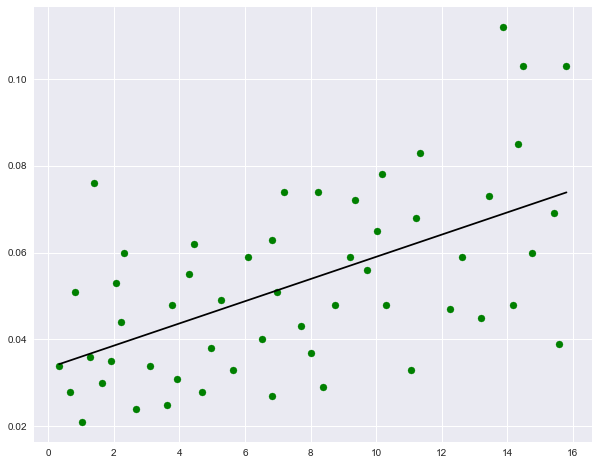

In [10]:
# fit a linear model to the filtered data
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit( new_dfP['Eccentricity'].values.reshape(-1, 1), new_dfP['Radius'].values.reshape(-1, 1))
bfly = lin_reg.predict( new_dfP['Eccentricity'].values.reshape(-1, 1) )

fig, ax = plt.subplots( figsize = (10,8) )
ax.scatter( x = new_dfP['Eccentricity'], y = new_dfP['Radius'], color = 'green')
ax.plot( new_dfP['Eccentricity'], bfly, 'k' )
plt.show()

                                 OLS Regression Results                                
Dep. Variable:                 Radius   R-squared (uncentered):                   0.811
Model:                            OLS   Adj. R-squared (uncentered):              0.807
Method:                 Least Squares   F-statistic:                              227.0
Date:                Mon, 15 Nov 2021   Prob (F-statistic):                    8.43e-21
Time:                        20:00:51   Log-Likelihood:                          123.29
No. Observations:                  54   AIC:                                     -244.6
Df Residuals:                      53   BIC:                                     -242.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

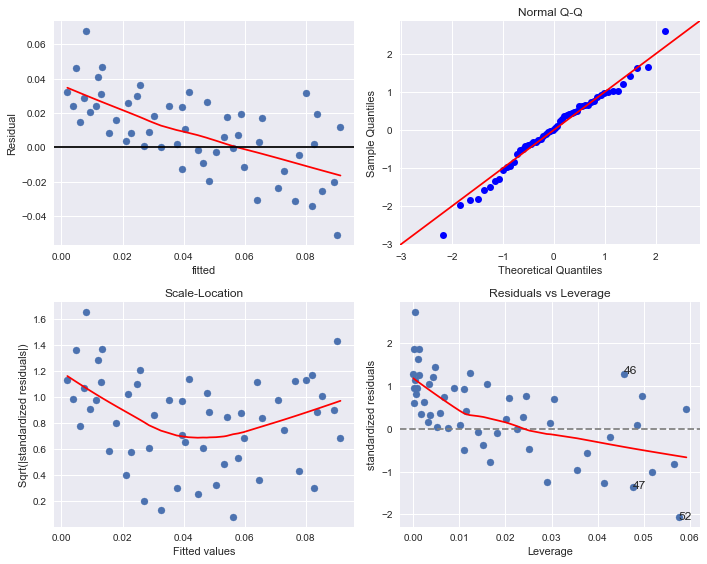

In [13]:
#plot diagnostic plots to analyse

data = [ new_dfP["Eccentricity"], new_dfP["Radius"]]
headers = ['x','y']
df_diagnostic = pd.concat(data, axis=1, keys=headers)
#res = linear_regression( df_diagnostic )
mod, res = linear_regression( df=new_dfP, x_cols=["Eccentricity"], y_cols=["Radius"] )
print( mod.summary() )
plot_diagnosis( res )

In [ ]:
#from the diagnostic plots, within 16.5 degrees, the receptive fields change by 0.0058 units for every change in 1 degree eccentricity.

## Consider the M Cells.

Perform a similar analysis for the M RGCs.

In [22]:
# choose a cutoff for the eccentricity and filter the data

dfM = df.loc[df['Class']=='M']
thres = 35
filtered_dfM = dfM[(dfM['Eccentricity'] < thres)]
new_dfM = filtered_dfM.reset_index()
new_dfM.head()

,index,Eccentricity,Radius,Class
0,0,3.525,0.098,M
1,1,6.234,0.093,M
2,2,6.531,0.122,M
3,3,7.718,0.105,M
4,4,8.386,0.123,M


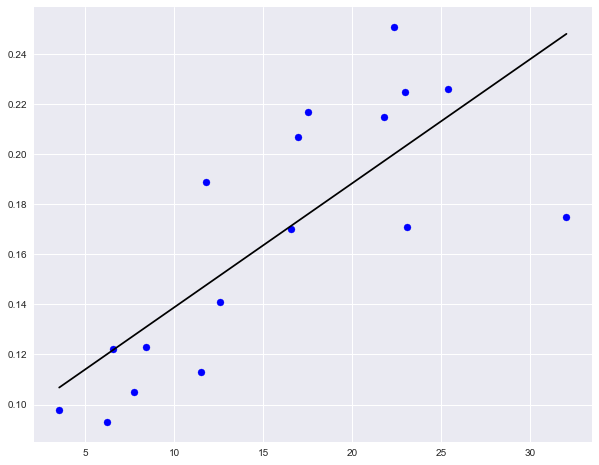

In [23]:
lin_reg = LinearRegression()
lin_reg.fit( new_dfM['Eccentricity'].values.reshape(-1, 1), new_dfM['Radius'].values.reshape(-1, 1))
bfly = lin_reg.predict( new_dfM['Eccentricity'].values.reshape(-1, 1) )

fig, ax = plt.subplots( figsize = (10,8) )
ax.scatter( x = new_dfM['Eccentricity'], y = new_dfM['Radius'], color = 'blue')
ax.plot( new_dfM['Eccentricity'], bfly, 'k' )
plt.show()


## Not So Simple Linear Regression

Let's consider the effects of both RGC class and Eccentricity on the RF size. To do this, we will perform a multiple linear regression. This model will incorporate both the numeric predictor 'Eccentricity' with the categorical feature 'Class' to predict RF 'Radius'.  

First we will need to recode the categorical predictor variable:

                                 OLS Regression Results                                
Dep. Variable:                 Radius   R-squared (uncentered):                   0.921
Model:                            OLS   Adj. R-squared (uncentered):              0.919
Method:                 Least Squares   F-statistic:                              515.8
Date:                Mon, 15 Nov 2021   Prob (F-statistic):                    1.12e-49
Time:                        20:08:14   Log-Likelihood:                          192.44
No. Observations:                  91   AIC:                                     -380.9
Df Residuals:                      89   BIC:                                     -375.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

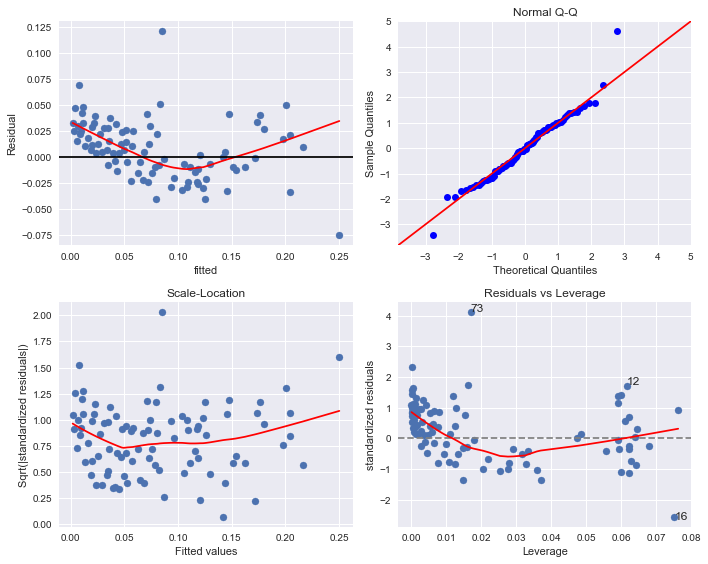

In [24]:
# use the pandas DataFrame method .get_dummies() to recode the 'Class' feature.
# get_dummies() will create 2 columns, 1 for each level of the 'Class' feature. 
# It is redundant to have both, so we will drop the first
df_onehot = pd.get_dummies( df )
#df_onehot = df_onehot[ df_onehot['Eccentricity']  ]

# define X,y
X = df_onehot[['Eccentricity', 'Class_M']]
y = df_onehot['Radius']

# fit a model
mod, res = linear_regression( df=df_onehot, x_cols=["Eccentricity", 'Class_M'], y_cols=["Radius"] )
print( mod.summary() )
plot_diagnosis( res )

## Interpret the Multiple Linear Regression

We can go over the model summary in class, but for now, how would you interpret the model coefficients for the predictors 'Eccenticity' and 'Class_M'?

<br><br>

In [ ]:
#For a change of 1 degree eccentricity, receptive field of M cells increases by 0.0051 units.
#Class_M shows that M cells have larger RF than P cell group while considering the Eccentricity to be constant